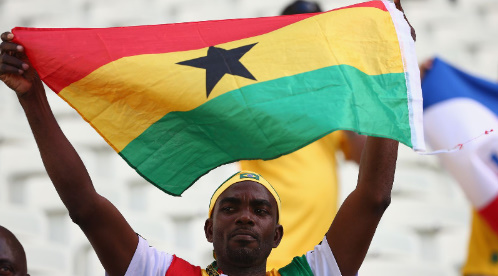

In [1]:
import numpy as np
import pandas as pd
from pandas import to_datetime

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# pip install pmdarima
import pmdarima as pm

from prophet import Prophet

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/ghana_gdp.zip', parse_dates=["year"], index_col = ["year"])
data = data.rename({'GDP (current US$)':'GDP'}, axis= 1)
display(data.head())
data.tail()

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


,GDP
year,
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


In [3]:
data.describe()

,GDP
count,6.200000e+01
mean,1.580793e+10
std,2.171517e+10
min,0.000000e+00
25%,2.831182e+09
50%,5.379735e+09
75%,1.801684e+10
max,7.759428e+10


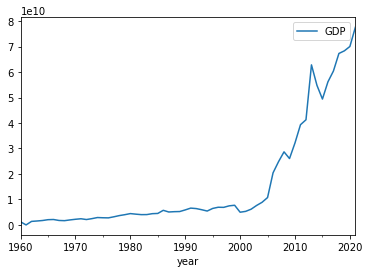

In [4]:
%matplotlib inline
data.plot();

In [5]:
# Откладываем последние три года из датасета как тестовую выборку для оценки результатов предсказания

train_df = data.loc[:'2019.01.01']
test_df = data.loc['2019.01.01':]
train_df.shape, test_df.shape

((60, 1), (3, 1))

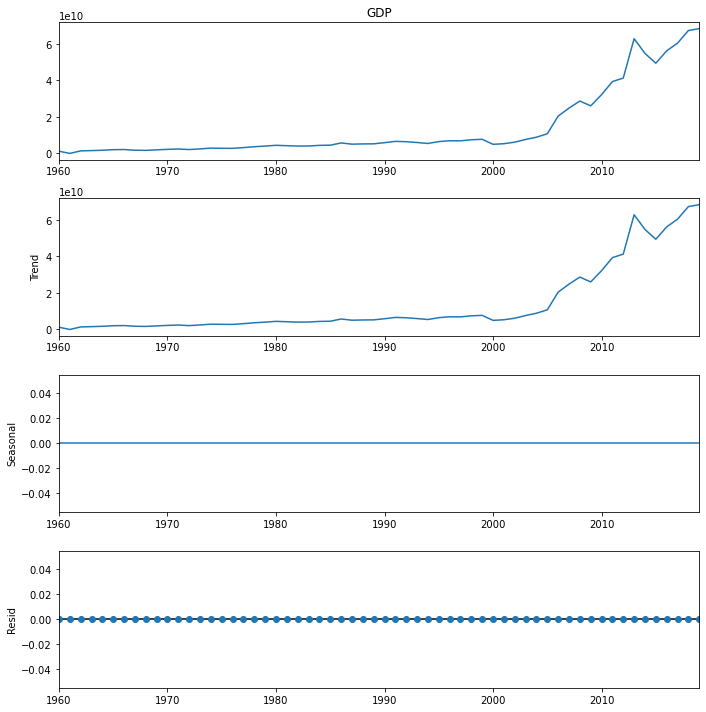

In [6]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 10, 10

result = seasonal_decompose(train_df.GDP, model='additive')
result.plot()
plt.show()

### При разложении отчетливо выделился тренд - увеличение ВВП. Сезонность не наблюдается (так как взяты годовые промежутки). Шума нет.

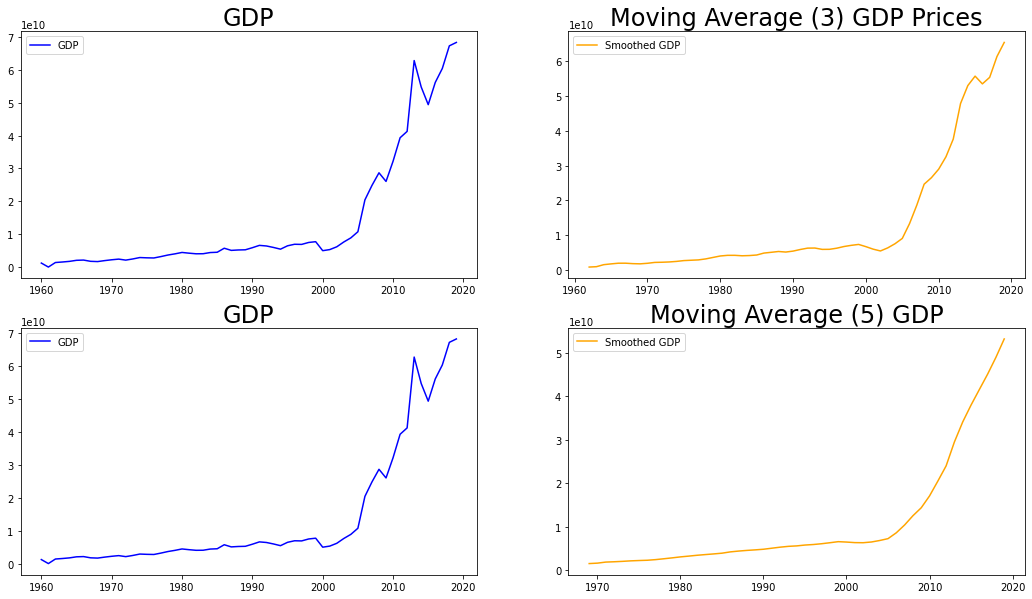

In [7]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в год (Window = 3) 
ax[0, 0].plot(train_df.GDP, color = "blue", label = "GDP")
ax[0, 0].set_title("GDP", size = 24)
ax[0, 0].legend()

ax[0, 1].plot(train_df.GDP.rolling(window=3).mean(), color = "orange", label = "Smoothed GDP")
ax[0, 1].set_title("Moving Average (3) GDP Prices", size = 24)
ax[0, 1].legend()


# Окно в год (Window = 5)
ax[1, 0].plot(train_df.GDP, color = "blue", label = "GDP")
ax[1, 0].set_title("GDP", size = 24)
ax[1, 0].legend()

ax[1, 1].plot(train_df.GDP.rolling(window=10).mean(), color = "orange", label = "Smoothed GDP")
ax[1, 1].set_title("Moving Average (5) GDP", size = 24)
ax[1, 1].legend()

### Сглаживание с шагом в 5 лет уже дает ровную линию изменения ВВП.

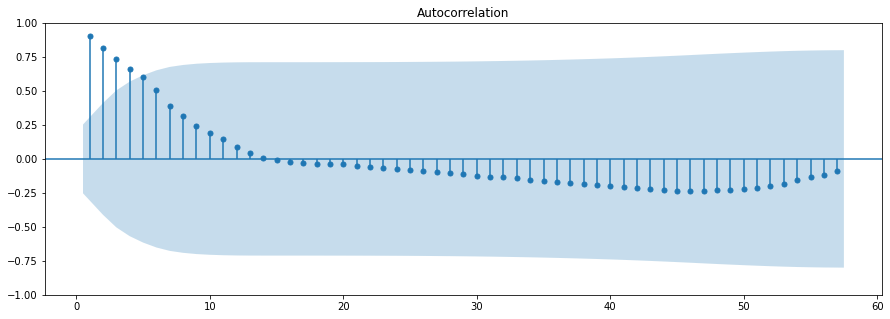

In [8]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 15, 5
sgt.plot_acf(train_df.GDP, zero = False, lags = 57)
plt.show()

Цены ВВП сильно коррелированы с последними годами. Корреляция сильно снижается и уходит в отрицательную величину с учетом более старых значений.

C:\Users\IBP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


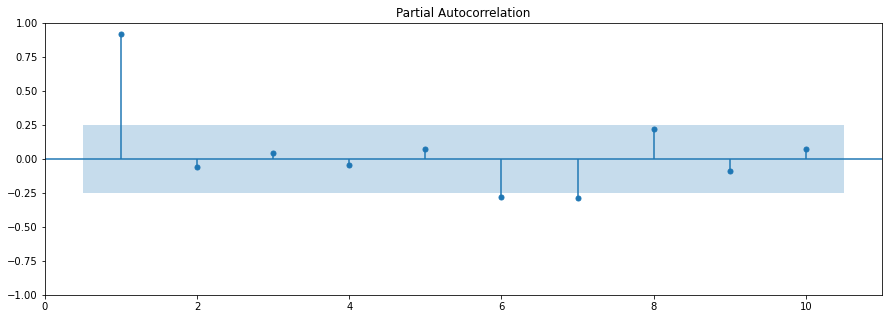

In [9]:
import statsmodels.graphics.tsaplots as sgt
plt.rcParams["figure.figsize"] = 15, 5
sgt.plot_pacf(train_df.GDP, zero = False, lags = 10)
plt.show()

Тут понятно только то, что параметр p выбирается =1.

In [10]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df['GDP'])

(0.5782902144237619,
 0.9870681153049116,
 10,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2239.7989988859235)

In [11]:
test1 = adfuller(train_df['GDP'])
print('adf: ', test1[0])
print('p-value: ', test1[1])
print('Critical values: ', test1[4])
if test1[0]>test1[4]['5%']:
    print('ряд нестационарен')
else:
    print('ряд стационарен')     

adf:  0.5782902144237619
p-value:  0.9870681153049116
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


Статистика теста больше всех критических значений, нулевую гипотезу ($H_0$) нельзя отвергнуть.

GDP не являются стационарными, следовательно дифференциреум. 

In [12]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)
    
    sgt.plot_acf(series, lags = 5, ax = axes[0])
    sgt.plot_pacf(series, lags = 5, ax = axes[1])
    plt.show()

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

C:\Users\IBP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


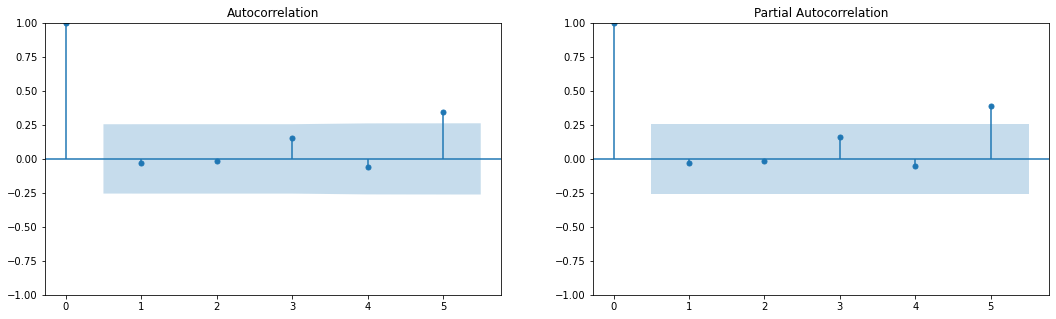

(-1.5585831471388791,
 0.5043580595671024,
 9,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2192.9443764954754)

In [13]:
plot_acf_pacf(train_df["GDP"].diff(1).dropna())
adfuller(train_df["GDP"].diff(1).dropna())


Первые разности не являются стационарными, дифференцируем еще.

C:\Users\IBP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


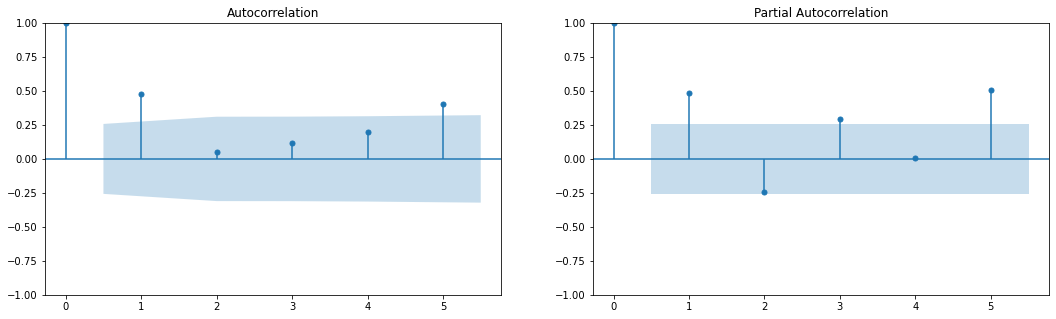

(-2.548632308727698,
 0.10408533220774713,
 11,
 46,
 {'1%': -3.5812576580093696,
  '5%': -2.9267849124681518,
  '10%': -2.6015409829867675},
 2153.408865167525)

In [14]:
plot_acf_pacf(train_df['GDP'].diff(2).dropna())
adfuller(train_df['GDP'].diff(2).dropna())

Минимальный уровень значимости по тесту adfuller равен 0.10


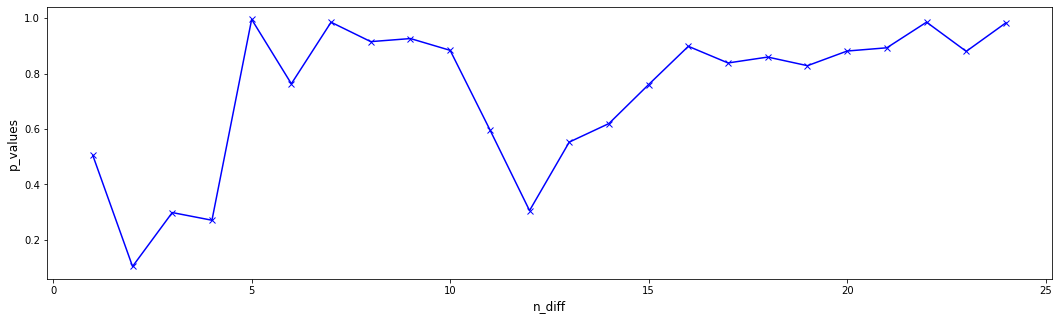

In [15]:
p_values = []
for i in range(1, 25):
  test1 = adfuller(train_df["GDP"].diff(i).dropna())
  p_values.append(test1[1])

print(f'Минимальный уровень значимости по тесту adfuller равен {min(p_values):.2f}')
plt.xlabel("n_diff", fontsize=12)
plt.ylabel("p_values", fontsize=12)
plt.plot([i for i in range(1, 25)], p_values, 'xb-');

Не достигается стационраность временного ряда даже при 25 дифференцированиях. Остановимся на одном (d=1)

### ARIMA, SARIMA
Начнем построение модели **ARIMA** со следующими параметрами:

* p = 1
* d = 1
* q = 5

Рассматривать сезонную модель **(SARMA)** не будем, так как отсутствует сезонность.

In [16]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df['GDP'].dropna(), order=(1, 1, 5))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

C:\Users\IBP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\IBP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\IBP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\IBP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   60
Model:                 ARIMA(1, 1, 5)   Log Likelihood               -1378.536
Date:                Wed, 06 Sep 2023   AIC                           2771.072
Time:                        08:55:13   BIC                           2785.615
Sample:                    01-01-1960   HQIC                          2776.749
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4935      0.313      1.578      0.115      -0.119       1.107
ma.L1         -0.5540      0.450     -1.232      0.218      -1.436       0.328
ma.L2         -0.1586      0.281     -0.565      0.572      -0.709       0.391
ma.L3          0.4436      0.445      0.996      0.319      -0.429       1.316
ma.L4         -0.2665      0.441     -0.605      0.545      -1.130       0.597
ma.L5          0.4930      0.317      1.553      0.120      -0.129       1.115
sigma2      1.662e+19   2.32e-20   7.15e+38      0.000    1.66e+19    1.66e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               232.93
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):             122.03   Skew:                             2.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.4e+55. Standard errors may be unstable.
"""

Второй столбец раздела I содержит некоторые полезные показатели, которые используются для сравнения различных моделей ARIMA. Как правило, модель с более высоким логарифмическим правдоподобием или более низким IC (AIC, BIC или HQIC) лучше, и наоборот.

In [17]:
pred_df = pd.DataFrame(index = data.index)
pred_df["model_preds"] = arima_model_fit.predict(start = test_df.index[1], end = test_df.index[-1])


pred_df["GDP"] = data["GDP"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP"]

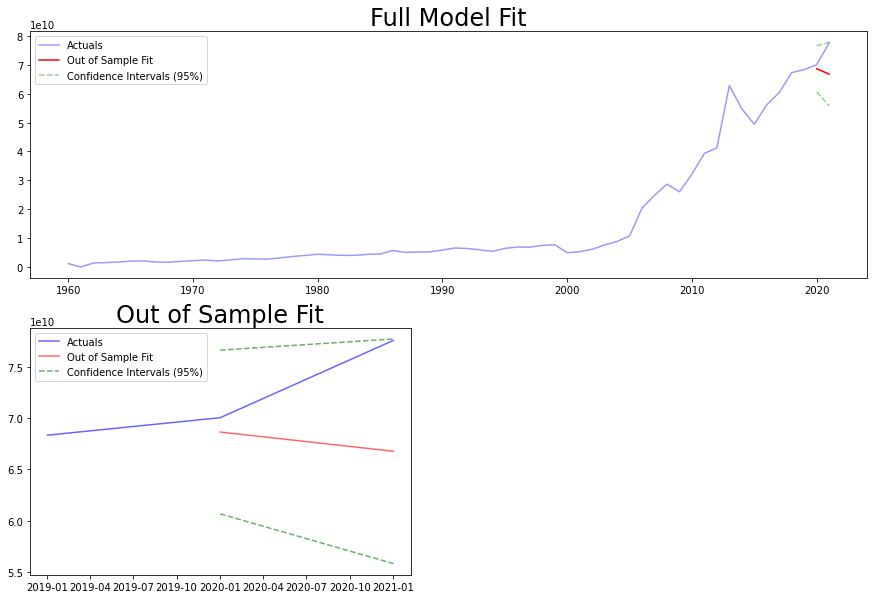

In [18]:
plt.rcParams["figure.figsize"] = 15, 10

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["GDP"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

### Предсказанные значения угадали тренд и немного оказались ниже, чем реальные

In [19]:
#!pip install pmdarima
import statsmodels
import pmdarima as pm

smodel = pm.auto_arima(train_df, start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, m=5,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=2543.058, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2550.216, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2542.275, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2541.388, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[5]             : AIC=2549.154, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[5]             : AIC=2543.288, Time=0.20 sec
 ARIMA(0,1,1)(0,1,2)[5]             : AIC=2543.145, Time=0.11 sec
 ARIMA(0,1,1)(1,1,0)[5]             : AIC=2543.076, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[5]             : AIC=2545.253, Time=0.21 sec
 ARIMA(0,1,0)(0,1,1)[5]             : AIC=2544.395, Time=0.05 sec
 ARIMA(0,1,2)(0,1,1)[5]             : AIC=2544.467, Time=0.08 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=2540.477, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=2549.742, Time=0.03 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=2542.356, Time=0.20 sec
 ARIMA(1,1,0)(0,1,2)[5]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   60
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 5)   Log Likelihood               -1267.239
Date:                             Wed, 06 Sep 2023   AIC                           2540.477
Time:                                     08:55:58   BIC                           2546.444
Sample:                                 01-01-1960   HQIC                          2542.778
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0733      0.125     -0.585      0.559      -0.319       0.173
ma.S.L5       -0.5617      0.133     -4.224      0.000      -0.822      -0.301
sigma2      1.775e+19   2.39e-21   7.41e+39      0.000    1.77e+19    1.77e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               387.36
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):             215.89   Skew:                             2.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.09e+55. Standard errors may be unstable.
"""

### Downsampling / Upsampling / Интерполяция

In [20]:
data.asfreq(freq='AS')

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [21]:
import numpy as np

data['GDP'] = data['GDP'].apply(lambda x: np.nan if x==0 else x)
data.isna().sum()

# Было одно нулевое значение, которое мы видели еще по методу describe

GDP    1
dtype: int64

### Запоним пропуск

In [22]:
data['GDP'] = data['GDP'].interpolate(method='linear')
data.isna().sum()

GDP    0
dtype: int64

In [23]:
train_df = data.loc[:'2019.01.01']
test_df = data.loc['2019.01.01':]
train_df.shape, test_df.shape

((60, 1), (3, 1))

C:\Users\IBP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


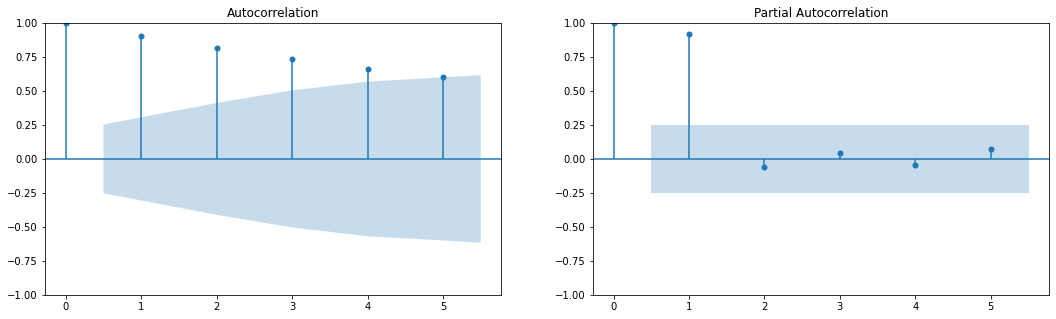

(0.5601921925450454,
 0.986592209795623,
 10,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2239.9127771450603)

In [24]:
plot_acf_pacf(train_df["GDP"].dropna())
adfuller(train_df["GDP"].dropna())

C:\Users\IBP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


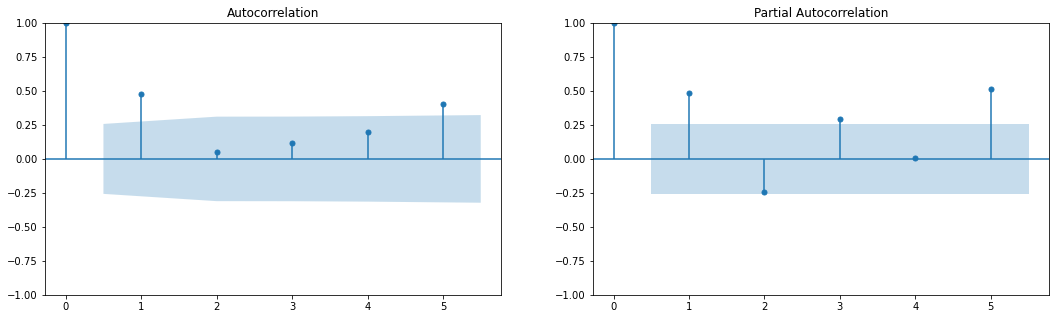

(-2.907972339035284,
 0.044428746334848404,
 11,
 46,
 {'1%': -3.5812576580093696,
  '5%': -2.9267849124681518,
  '10%': -2.6015409829867675},
 2150.672724703065)

In [25]:
plot_acf_pacf(train_df['GDP'].diff(2).dropna())
adfuller(train_df['GDP'].diff(2).dropna())

In [26]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt

arima_model = ARIMA(train_df["GDP"].dropna(), order = (2, 2, 5))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

C:\Users\IBP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\IBP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\IBP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\IBP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   60
Model:                 ARIMA(2, 2, 5)   Log Likelihood               -1357.325
Date:                Wed, 06 Sep 2023   AIC                           2730.650
Time:                        08:56:29   BIC                           2747.133
Sample:                    01-01-1960   HQIC                          2737.070
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7476      0.327     -5.345      0.000      -2.388      -1.107
ar.L2         -0.9135      0.360     -2.535      0.011      -1.620      -0.207
ma.L1          0.8831      0.410      2.154      0.031       0.079       1.687
ma.L2         -1.0108      0.350     -2.887      0.004      -1.697      -0.325
ma.L3         -0.8585      0.679     -1.264      0.206      -2.190       0.473
ma.L4          0.3911      0.360      1.086      0.277      -0.315       1.097
ma.L5          0.3196      0.504      0.634      0.526      -0.668       1.307
sigma2      1.915e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               126.07
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             365.32   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.65e+55. Standard errors may be unstable.
"""

In [27]:
pred_df = pd.DataFrame(index = data.index)
pred_df["model_preds"] = arima_model_fit.predict(start = test_df.index[1], end = test_df.index[-1])


pred_df["GDP"] = data["GDP"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP"]

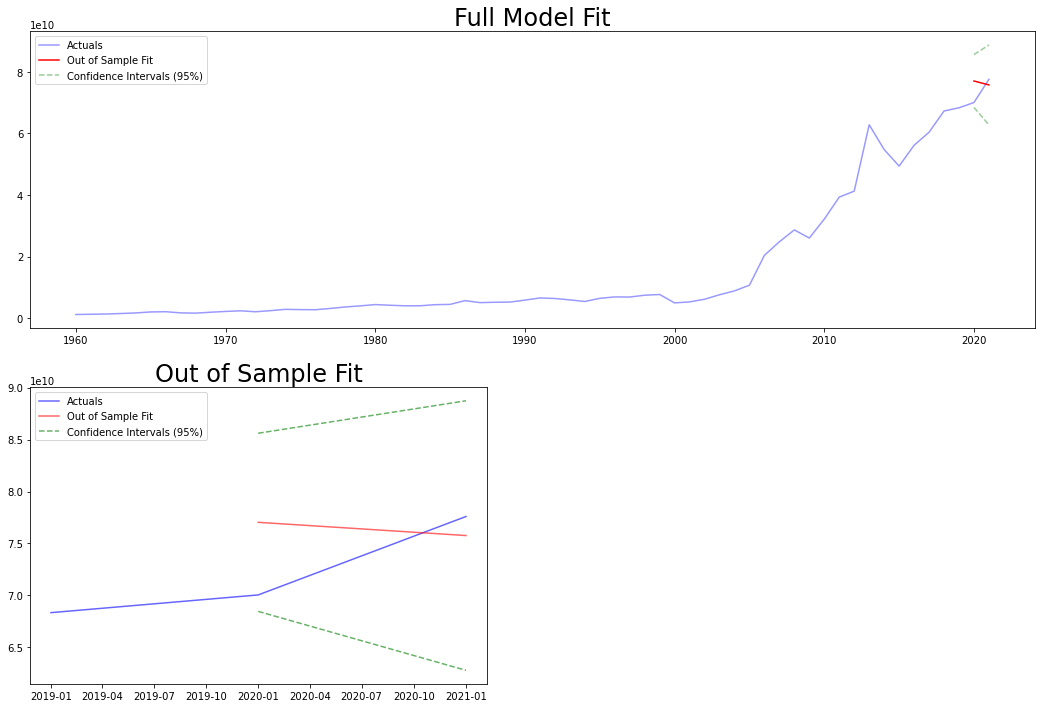

In [28]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["GDP"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

### <center> Валидация временных рядов

In [37]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3, test_size=7)

train_test_groups = tscv.split(data.GDP) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


### <center> Волатильность

 **Volatility** at time **t**  
 Функция pct_change(1)

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

In [38]:
# data["GDP_vol"] = (data.GDP - data.GDP.shift(1))/data.GDP.shift(1)

data["GDP_vol"] = data.GDP.pct_change(1).mul(100).abs()
data["GDP_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP_vol, dtype: float64

<AxesSubplot:xlabel='year'>

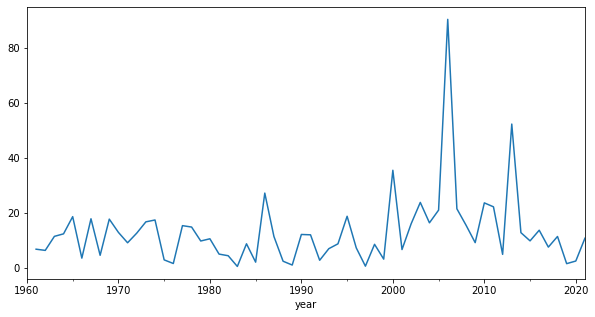

In [39]:
data['GDP_vol'].plot()

C:\Users\IBP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


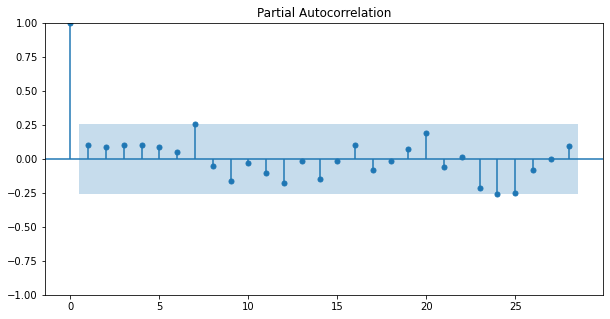

In [70]:
from matplotlib import pyplot as plt

train_df = data.loc[:"2019-01-01"]
test_df = data.loc["2019-01-01":]

plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df.GDP_vol[1:], lags = 28)
plt.show()

In [71]:
adfuller(train_df.GDP_vol[1:])

(-6.7265034097248995,
 3.379140565297867e-09,
 0,
 58,
 {'1%': -3.548493559596539,
  '5%': -2.912836594776334,
  '10%': -2.594129155766944},
 390.63418032580034)

Глядя на графики PACF для доходности и волатильности, становится ясно, что самый значтельный - 2 (7) ?? лаг, а затем уровни значимости значительно падают. Итак, мы построим модель GARCH(2, 2).

In [35]:
# conda install arch
!pip install arch
# %conda install -c conda-forge arch-py

In [72]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(data["GDP_vol"].loc[data.index]) 

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df. 
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее 
# для сглаживания, то необходимо передать измененный train_df датасет. 

# garch_df.at[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()
garch_df.loc[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()

In [73]:
from arch import arch_model
model = arch_model(garch_df["GDP_vol"].dropna(), p = 2, q = 7, vol = "GARCH")

# в параметре last_obs указываем последний объект, до которого будем совершать обучение. 
# в нашем случае это до первого объекта из test выборки 

model_results = model.fit(last_obs = test_df.index[0], update_freq = 5)

Iteration:      5,   Func. Count:     63,   Neg. LLF: 227.0825858389692
Iteration:     10,   Func. Count:    123,   Neg. LLF: 226.98072856419344
Iteration:     15,   Func. Count:    183,   Neg. LLF: 226.58644463391377
Iteration:     20,   Func. Count:    266,   Neg. LLF: 226.6217741907382
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.62167553484815
            Iterations: 25
            Function evaluations: 313
            Gradient evaluations: 24


In [74]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.622
Distribution:                  Normal   AIC:                           475.243
Method:            Maximum Likelihood   BIC:                           497.908
                                        No. Observations:                   58
Date:                Wed, Sep 06 2023   Df Residuals:                       57
Time:                        10:34:27   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3931      1.681      7.374  1.661e-13 [  9.099, 15.687]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         16.9217     51.636      0.328      0.743    [-84.283,1.181e+02]
alpha[1]   5.8816e-13  2.896e-02  2.031e-11      1.000 [-5.677e-02,5.677e-02]
alpha[2]   9.1939e-03  3.040e-02      0.302      0.762 [-5.040e-02,6.879e-02]
beta[1]        0.0000      1.324      0.000      1.000      [ -2.596,  2.596]
beta[2]        0.0000      0.957      0.000      1.000      [ -1.875,  1.875]
beta[3]        0.0000  3.513e-02      0.000      1.000 [-6.885e-02,6.885e-02]
beta[4]        0.0000  4.832e-02      0.000      1.000 [-9.470e-02,9.470e-02]
beta[5]        0.9908      0.323      3.063  2.189e-03      [  0.357,  1.625]
beta[6]        0.0000      1.634      0.000      1.000      [ -3.202,  3.202]
beta[7]        0.0000      1.157      0.000      1.000      [ -2.267,  2.267]
=============================================================================

Covariance estimator: robust
"""

Covariance estimator: robust
    
**Вывод:** Параметр **AIC**  уменьшился до 475 с 2270.

In [75]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]

C:\Users\IBP\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


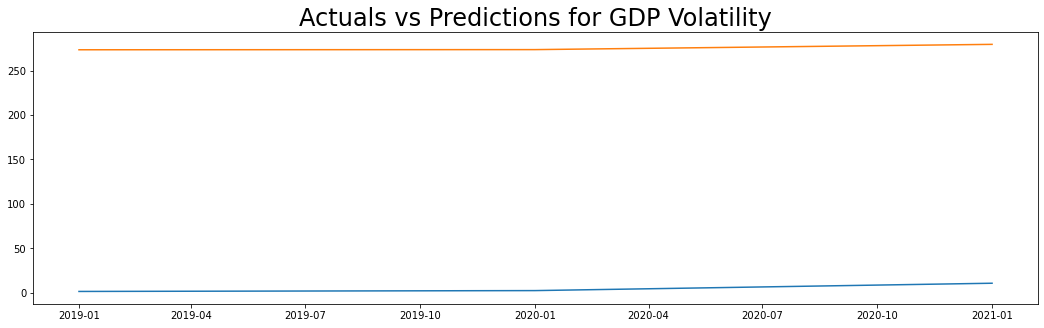

In [76]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP Volatility", size = 24)

plt.show()

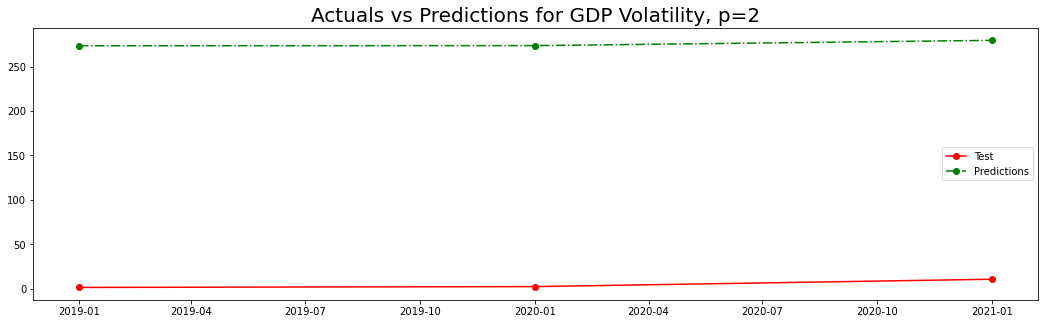

In [85]:
# plt.rcParams["figure.figsize"] = 18, 5
plt.plot(predictions_df["GDP_vol"].abs(), 'o-r', label='Test')
plt.plot(predictions_df["Predictions"], 'o-.g', label='Predictions')
plt.title("Actuals vs Predictions for GDP Volatility, p=2", size = 20)
plt.legend()
# plt.show()

Вывод: так как в предсказания были лишь по 3 значениям, то получилась "почти" прямая линия

In [86]:
import numpy as np
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(predictions_df['GDP_vol'].abs(), predictions_df['Predictions']))

270.50500318387463

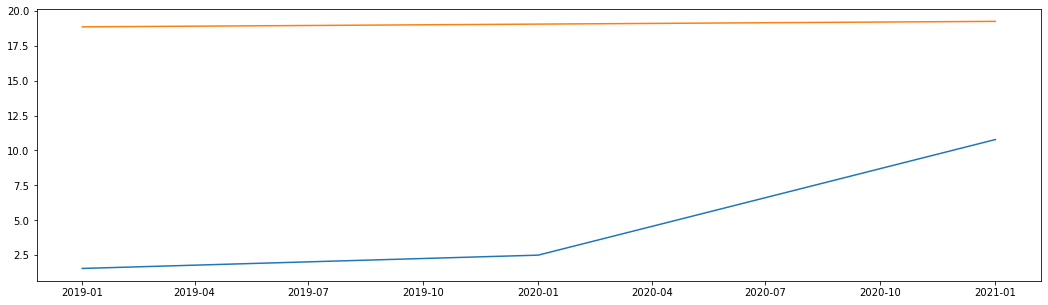

In [83]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data['GDP_vol'].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(data['GDP_vol'].shape[0]))[train_df.shape[0]-1:].fillna(0)
y_train = train_df['GDP_vol'].fillna(0)
y_test = test_df['GDP_vol'].fillna(0)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))

year
2019-01-01    273.351587
2020-01-01    273.527807
2021-01-01    279.444985
Name: Predictions, dtype: float64

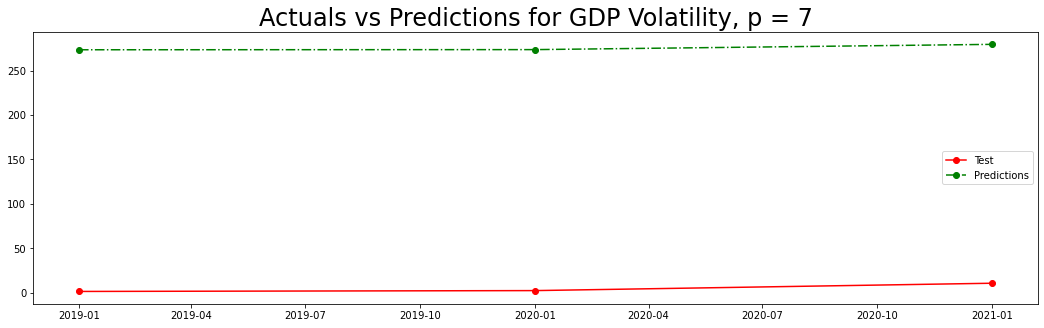

In [88]:
# p = 7
# plt.rcParams["figure.figsize"] = 18, 5
plt.plot(predictions_df["GDP_vol"].abs(), 'o-r', label='Test')
plt.plot(predictions_df["Predictions"], 'o-.g', label='Predictions')
plt.title("Actuals vs Predictions for GDP Volatility, p = 7", size = 24)
plt.legend()
display(predictions_df["Predictions"])

In [89]:
np.sqrt(mean_squared_error(lr_predict, y_test))

14.67025702262042

Линейная модель на маленьких данных оказалась лучше.

In [91]:
# conda install prophet
train_df = data.loc[:"2017-12-31"]
test_df = data.loc["2018-01-01":]

train_df['ds'] = train_df.index
test_df['ds'] = test_df.index

train_df['ds']= to_datetime(train_df['ds'])
test_df['ds']= to_datetime(test_df['ds'])

train_df.rename(columns = {'GDP_vol':'y'}, inplace = True)
test_df.rename(columns = {'GDP_vol':'y'}, inplace = True)
# train_df

train_df.reset_index(drop= True , inplace= True )
test_df.reset_index(drop= True , inplace= True )

C:\Users\IBP\AppData\Local\Temp/ipykernel_12192/1987082156.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['ds'] = train_df.index
C:\Users\IBP\AppData\Local\Temp/ipykernel_12192/1987082156.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ds'] = test_df.index
C:\Users\IBP\AppData\Local\Temp/ipykernel_12192/1987082156.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [92]:
model = Prophet()
model.fit(train_df)

11:28:08 - cmdstanpy - INFO - Chain [1] start processing
11:28:09 - cmdstanpy - INFO - Chain [1] done processing


In [93]:
# future_df = model.make_future_dataframe(periods=3)
# future_df.tail()
test_df['ds'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4 entries, 0 to 3
Series name: ds
Non-Null Count  Dtype         
--------------  -----         
4 non-null      datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 160.0 bytes


In [94]:
# forecast_df = model.predict(future_df)
forecast_df = model.predict(test_df)
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01,21.431859,4.357870,38.223318
1,2019-01-01,20.424871,4.107132,37.242951
2,2020-01-01,18.574855,2.067560,36.031689
3,2021-01-01,22.543549,5.643459,39.331795


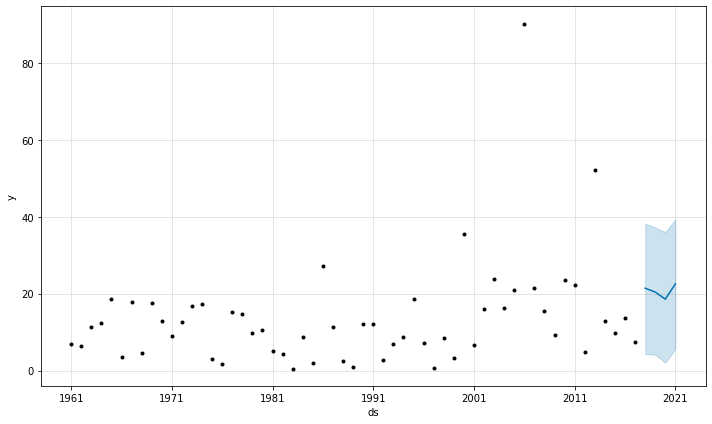

In [95]:
fig = model.plot(forecast_df)

,GDP,y,ds
0,6.729928e+10,11.410877,2018-01-01
1,6.833754e+10,1.542746,2019-01-01
2,7.004320e+10,2.495937,2020-01-01
3,7.759428e+10,10.780603,2021-01-01


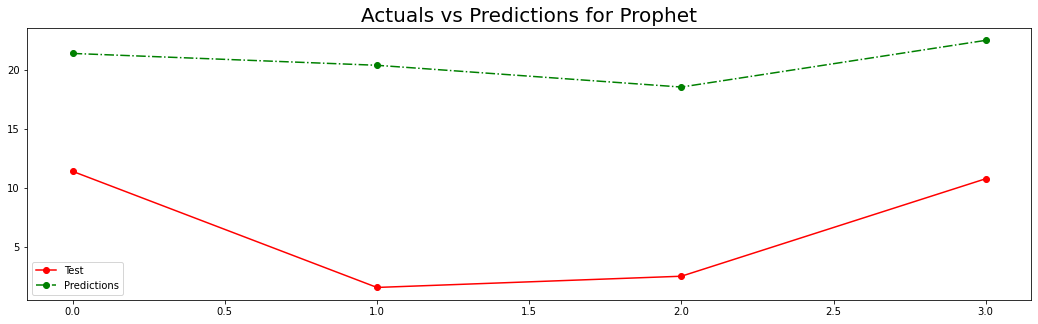

In [96]:
plt.plot(test_df['y'], 'o-r', label='Test')
plt.plot(forecast_df['yhat'], 'o-.g', label='Predictions')
plt.title("Actuals vs Predictions for Prophet", size = 20)
plt.legend()
display(test_df)

In [97]:
np.sqrt(mean_squared_error(test_df['y'], forecast_df['yhat']))

14.610383649313277

Модель **Prophet** - показала чуть лучше прогноз, чем **лингейная регрессия.** Также есть некое подобие тестовой зависимости и прогноза.